In [33]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.image as mpimg
import os
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
from sklearn.metrics import confusion_matrix
import json
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score
import matplotlib.dates as mdates
import mplfinance as mpf
from dataset import get_dataloader, plot_statistical_analysis
from torch.utils.data import Subset
import random
from models import load_model_squeezenet
from performance import plot_full_evaluation_dashboard
from inference import inference, inference_df
from create_training_data import plot_rgb

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import Dataset, DataLoader

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [34]:
def scale (col) :
    name = col.columns[0]
    if 'RSI' in name :
        print('RSI')
        return col*0.01
    elif 'ADX' in name :
        print('ADX')
        return col*0.01
    elif 'CCI' in name :
        print('CCI')
        return (col + 1)*0.2
    elif 'STOCH' in name :
        print('STOCH')
        return col*0.01
    else :
        return col

In [73]:
def plot_rgb(data, names, pixel_size=256, dpi=100, labelled = False, scaled = False, show_axis = False):
    """
    Trace les séries par groupe de 3 en RGB, et sauvegarde une image exacte en pixels (ex: 256x256),
    en contrôlant la taille via figsize + dpi. Aucun buffer utilisé.
    """
    plt.style.use('dark_background')
    num_groups = int(np.ceil(len(names) / 3))

    # Taille en pouces = pixels / dpi
    fig_height_inches = pixel_size / dpi
    fig = plt.figure(figsize=(fig_height_inches, fig_height_inches), dpi=dpi)

    # Positionnement manuel des subplots
    for i in range(num_groups):
        ax = fig.add_axes([0, 1 - (i + 1)/num_groups, 1, 1/num_groups])  # [left, bottom, width, height]
        group_names = names[i*3:(i+1)*3]
        colors = ['red', 'green', 'blue']

        for j, name in enumerate(group_names):
            #print(data[[name]].columns)
            #scaled = scale(data[[name]])
            ax.plot(data[[name]], color=colors[j], linewidth=1, label = name)
            if labelled :
                ax.legend()
        if scaled :
            ax.set_ylim(0,1)
        if not show_axis :
            ax.axis('off')
    
    return fig

Index(['MACD (12,26,9)'], dtype='object')
Index(['STOCH-R (14)'], dtype='object')
STOCH
Index(['STOCH-RL (15,15,1)'], dtype='object')
STOCH
Index(['RSI (14)'], dtype='object')
RSI
Index(['ADX (14)'], dtype='object')
ADX
Index(['CCI (20)'], dtype='object')
CCI


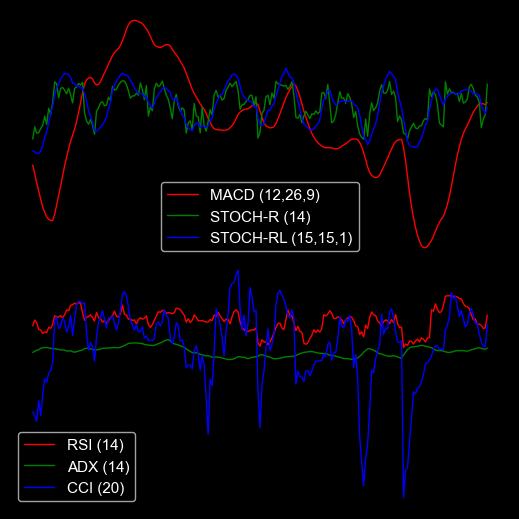

In [36]:
test_file = pd.read_csv('test\\HON_100.csv')

plot_rgb(test_file, test_file.columns[1:], pixel_size= 500)

plt.show()

In [37]:
pred = 15
min_size = 50
max_size = 300
file_path = "Base_Test_2500pts v-Louis.xlsx"
graph_size = 156

data = pd.ExcelFile(file_path)

sheet_names = data.sheet_names

INDICS = ['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)']
train_sheets = ['BIIB', 'WMT', 'KO', 'CAT', 'BA', 'MMM', 'AAPL']

global_values = {}

for indic in INDICS :
    global_values[indic] = []

for sheet_name in train_sheets :
    sheet = data.parse(sheet_name)
    for indic in INDICS :
        global_values[indic] += sheet[indic].dropna().tolist()

In [38]:
import pandas as pd
import numpy as np

# Create a DataFrame from the global_values dictionary
global_df = pd.DataFrame({indic: pd.Series(values) for indic, values in global_values.items()})

# Basic statistical summary using describe
basic_stats = global_df.describe()

# Additional statistics
additional_stats = pd.DataFrame({
    "skewness": global_df.skew(),
    "kurtosis": global_df.kurtosis(),
    "missing_values": global_df.isnull().sum(),
    "zero_values": (global_df == 0).sum(),
    "median": global_df.median(),
    "mode": global_df.mode().iloc[0],
    "variance": global_df.var(),
    "range": global_df.max() - global_df.min(),
})

# Combine the basic and additional statistics into a complete view
full_stats = pd.concat([basic_stats, additional_stats.T])

# Display or save the stats
print(basic_stats)

       MACD (12,26,9)  STOCH-R (14)  STOCH-RL (15,15,1)      RSI (14)  \
count    17241.000000  17241.000000        17241.000000  17241.000000   
mean         0.526154     55.347429           55.323342     51.288594   
std          3.473884     30.273292           36.710671     12.137437   
min        -29.611812      0.000000          -41.793027      7.177954   
25%         -0.855294     28.563536           24.804701     42.986079   
50%          0.391001     58.902182           58.731017     51.240876   
75%          1.615929     82.857143           86.390448     59.598764   
max         24.153026    100.000000          133.862497     93.718487   

           ADX (14)      CCI (20)  
count  17241.000000  17241.000000  
mean      23.050166      0.236305  
std        9.681637      2.009588  
min        5.713605    -11.675835  
25%       15.695879     -1.052934  
50%       20.948170      0.402677  
75%       28.848913      1.601360  
max       67.155057     10.386785  


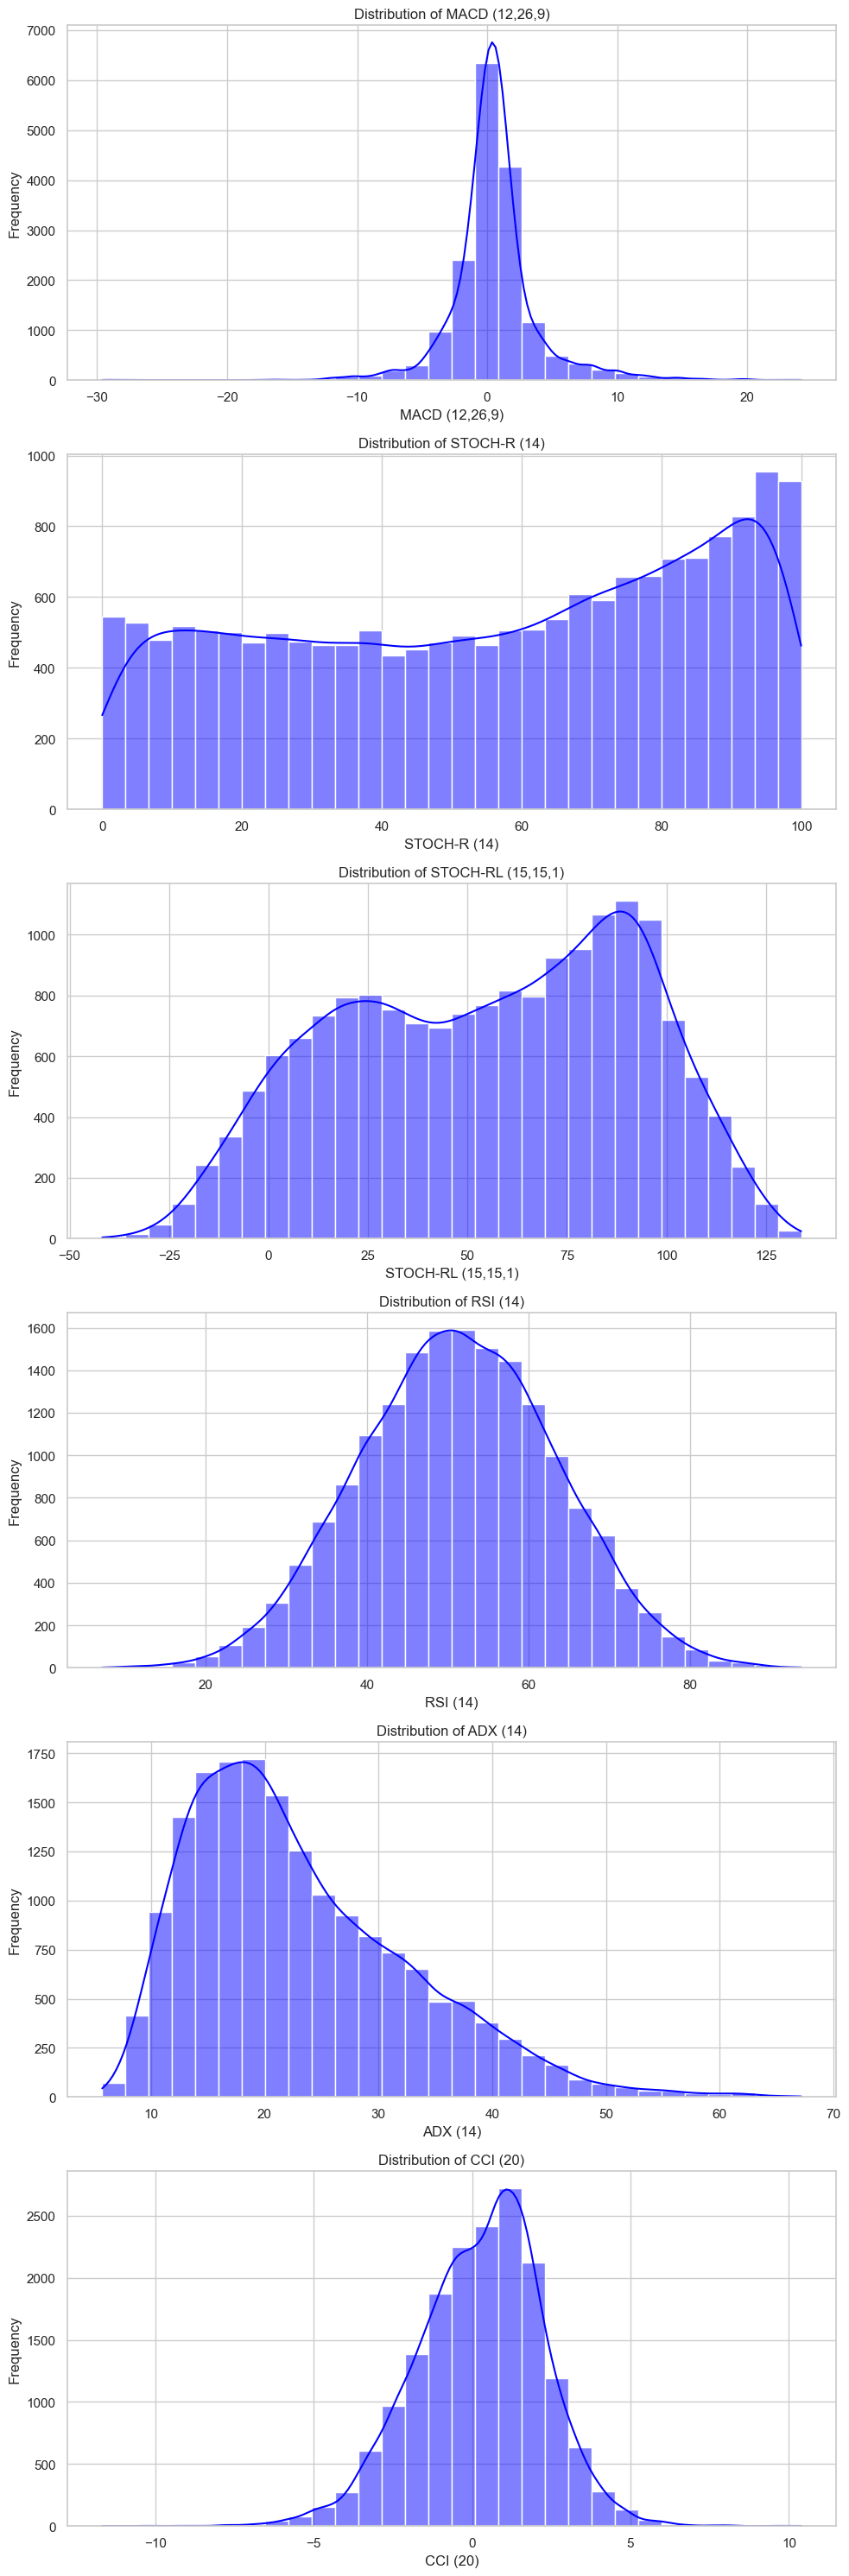

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style for the plots
sns.set(style="whitegrid")

# Create a figure with subplots for each indicator
fig, axes = plt.subplots(nrows=len(INDICS), ncols=1, figsize=(10, 5 * len(INDICS)))

# Loop over each indicator and plot its distribution
for idx, indic in enumerate(INDICS):
    ax = axes[idx]
    # Plot the histogram and KDE on the same plot
    sns.histplot(global_df[indic], kde=True, ax=ax, color="blue", bins=30)
    ax.set_title(f'Distribution of {indic}')
    ax.set_xlabel(f'{indic}')
    ax.set_ylabel('Frequency')

# Adjust layout to make sure everything fits
plt.tight_layout()
plt.show()


In [40]:
from scipy.stats import rankdata
import pandas as pd

# Create a new DataFrame to store transformed values
uniform_df = pd.DataFrame()

# Apply ECDF-based transform to each indicator
for indic in INDICS:
    x = pd.Series(global_values[indic])
    # Remove NaNs if necessary
    x = x.dropna()
    # Rank data and scale to [0, 1]
    transformed = (rankdata(x, method='average') - 1) / (len(x) - 1)
    # Fill back into DataFrame, aligning with original index
    uniform_df[indic] = pd.Series(transformed, index=x.index)

# Now uniform_df contains values close to Uniform(0, 1)


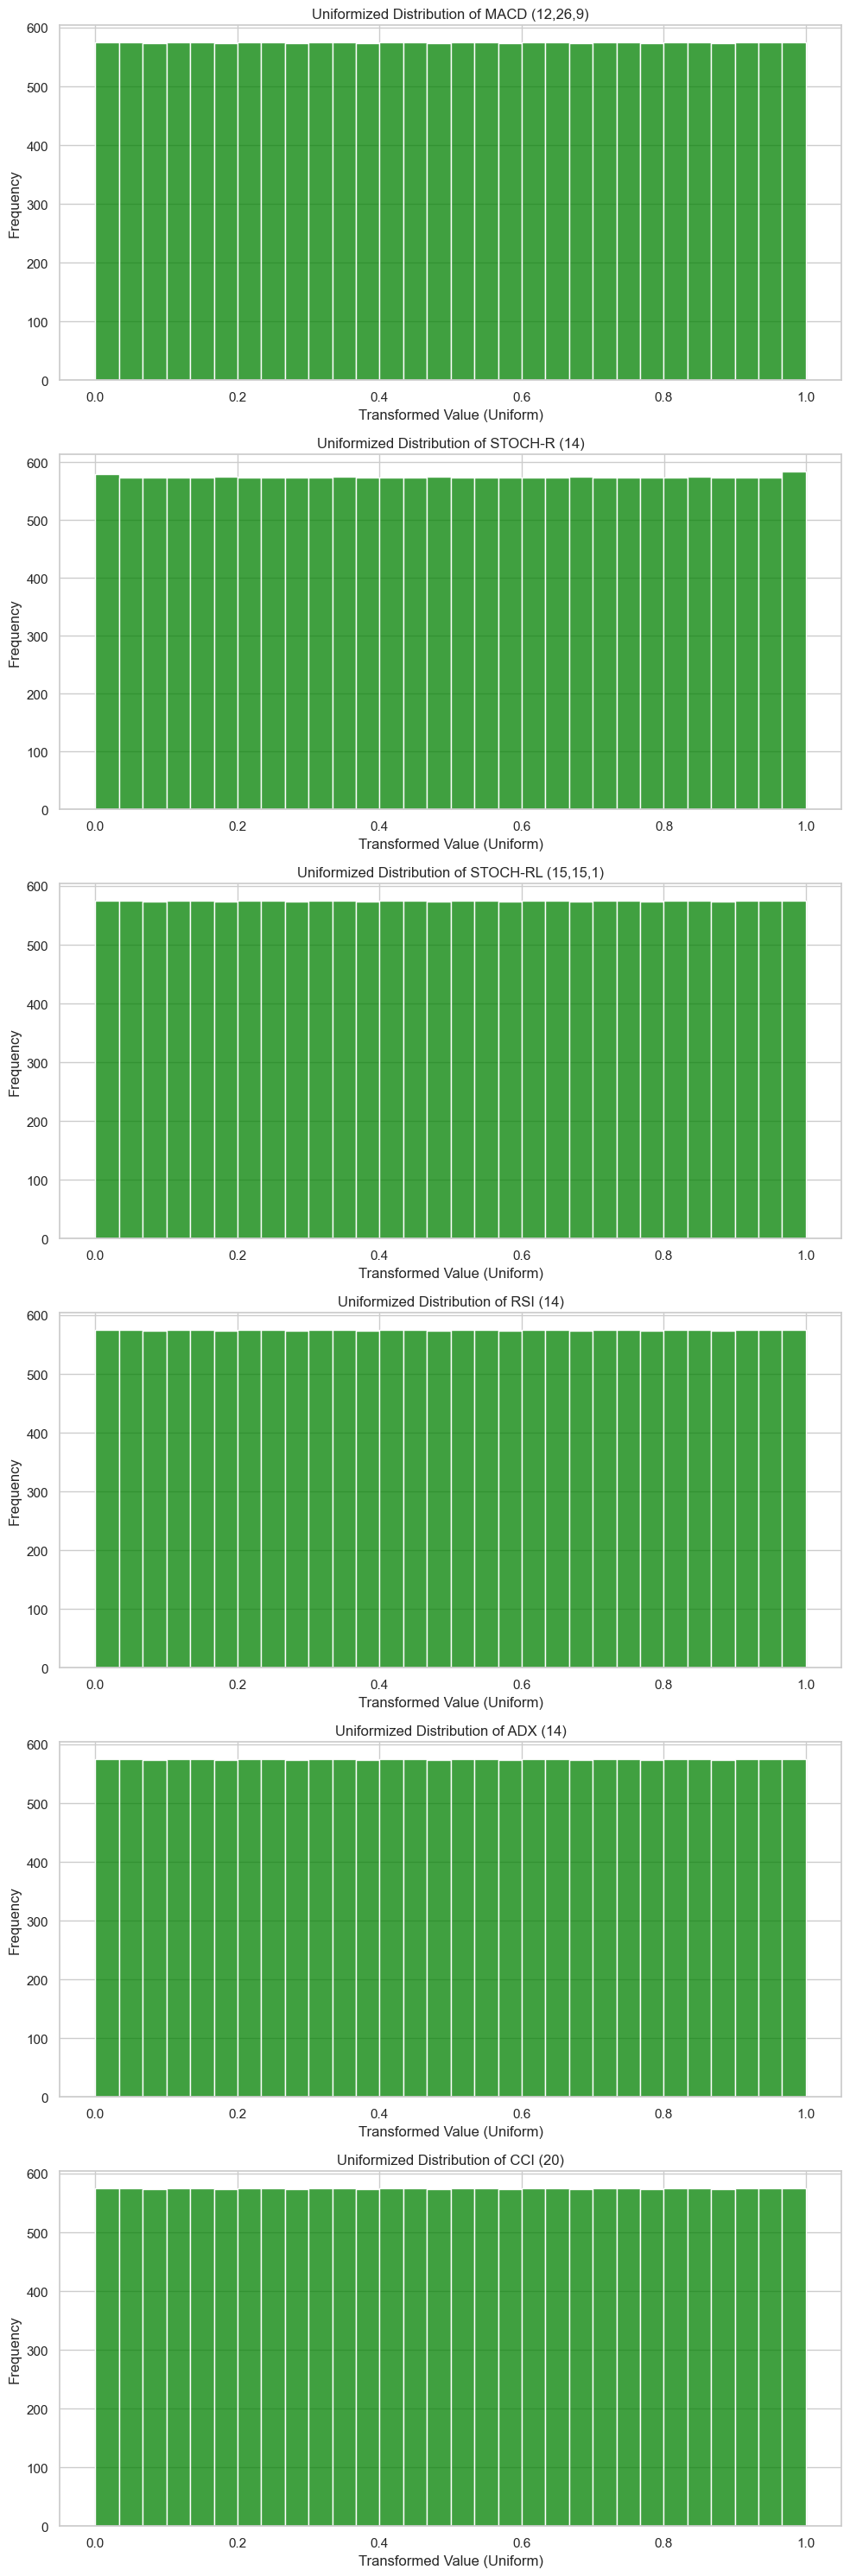

In [41]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")
fig, axes = plt.subplots(nrows=len(INDICS), ncols=1, figsize=(10, 5 * len(INDICS)))

for idx, indic in enumerate(INDICS):
    ax = axes[idx]
    sns.histplot(uniform_df[indic], kde=False, bins=30, ax=ax, color="green")
    ax.set_title(f'Uniformized Distribution of {indic}')
    ax.set_xlabel('Transformed Value (Uniform)')
    ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()


In [53]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d

class ECDFScaler:
    def __init__(self):
        self.ecdf_functions = {}

    def fit(self, df: pd.DataFrame):
        """
        Fit the ECDF scaler using the columns of the large DataFrame.
        """
        for col in df.columns:
            x = df[col].dropna().sort_values().values
            # ECDF: unique sorted values and their cumulative probabilities
            y = np.linspace(0, 1, len(x), endpoint=True)
            # Store the interpolator for each feature
            self.ecdf_functions[col] = interp1d(
                x, y, bounds_error=False, fill_value=(0.0, 1.0)
            )

    def transform(self, df: pd.DataFrame) -> pd.DataFrame:
        """
        Apply the fitted ECDF to transform a new DataFrame.
        """
        transformed = pd.DataFrame(index=df.index)
        for col in df.columns:
            if col in self.ecdf_functions:
                x = df[col].values
                f = self.ecdf_functions[col]
                transformed[col] = f(x)
            else:
                transformed[col] = df[col]
        return transformed

    def fit_transform(self, df: pd.DataFrame) -> pd.DataFrame:
        self.fit(df)
        return self.transform(df)


In [58]:
# Convert global_values into DataFrame
global_df = pd.DataFrame({indic: pd.Series(values) for indic, values in global_values.items()})

print(global_df.head())

# Fit the ECDF scaler
scaler = ECDFScaler()
scaler.fit(global_df)

scaler.ecdf_functions.keys()


   MACD (12,26,9)  STOCH-R (14)  STOCH-RL (15,15,1)   RSI (14)  ADX (14)  \
0        0.075780     66.622416           57.680556  55.649631  7.035714   
1        0.100003     84.710835           65.787751  47.113082  6.604592   
2        0.105158     56.902676           69.720888  45.745851  6.561407   
3        0.097389     56.192280           70.838407  46.615912  7.092735   
4        0.090028     68.979399           75.295683  53.199313  7.014682   

   CCI (20)  
0  1.604976  
1  2.191569  
2  0.579829  
3 -1.037490  
4  0.200557  


dict_keys(['MACD (12,26,9)', 'STOCH-R (14)', 'STOCH-RL (15,15,1)', 'RSI (14)', 'ADX (14)', 'CCI (20)'])

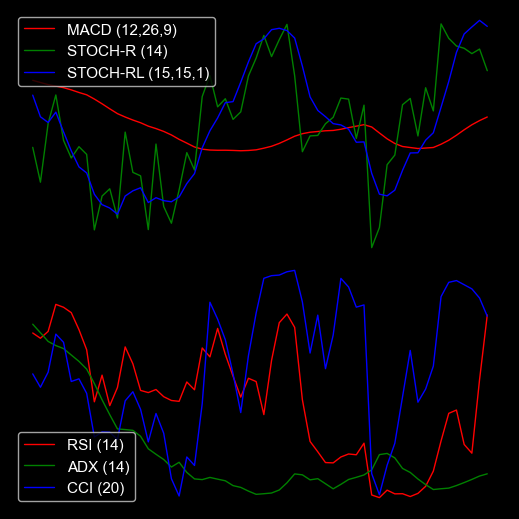

In [59]:
test_file = scaler.transform(pd.read_csv('test\\HON_0.csv'))


plot_rgb(test_file, test_file.columns[1:], pixel_size= 500)

plt.show()

In [66]:
indicator_bounds = {
    'MACD (12,26,9)': (-5, 5),
    'STOCH-R (14)': (0, 100),
    'STOCH-RL (15,15,1)': (0, 100),
    'RSI (14)': (0, 100),
    'ADX (14)': (0, 100),
    'CCI (20)': (-200, 200),
}

def robust_minmax_scale(df, bounds = indicator_bounds):
    scaled = pd.DataFrame(index=df.index)
    for col in df.columns:
        if col in bounds.keys() :
            lower, upper = bounds[col]
            clipped = df[col].clip(lower=lower, upper=upper)
            scaled[col] = (clipped - lower) / (upper - lower)
        else :
            scaled[col] = df[col]
    return scaled

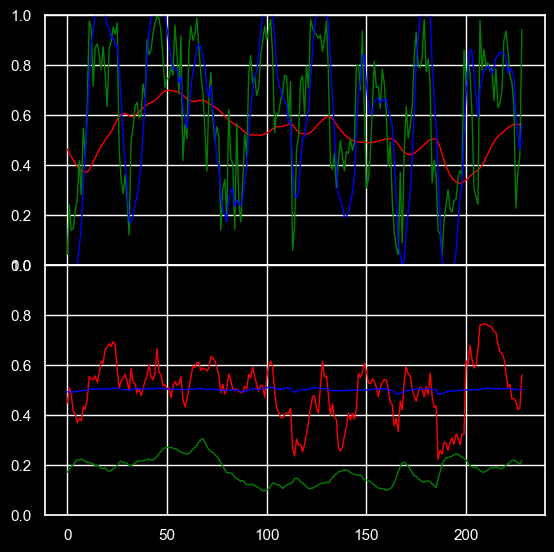

In [76]:
test_file = robust_minmax_scale(pd.read_csv('test\\HON_100.csv'))


plot_rgb(test_file, test_file.columns[1:], pixel_size= 500, scaled = True, show_axis= True)

plt.show()

In [ ]:
def robust_zscore(df):
    med = df.median()
    iqr = df.quantile(0.75) - df.quantile(0.25)
    return (df - med) / iqr

scaled_df = robust_zscore(global_df)
